# 04. Model Evaluation & Analysis

## 🎯 Objectives
This notebook focuses on evaluating the trained Hybrid Quantum Neural Network (HQNN) model. We will:
1.  **Load the Trained Model** from the saved checkpoint.
2.  **Load Test Data** using the preprocessing pipeline.
3.  **Calculate Metrics** (Precision, Recall, F1-Score, AUC).
4.  **Visualize Results** (Confusion Matrix, ROC Curve).

In [1]:
import sys
import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Ensure we can import from the ml_engine directory
sys.path.append(os.path.abspath('..'))

from ml_engine.dataset import CreditCardDataset
from ml_engine.models.hybrid_nn import HybridQNN
from ml_engine.config import HQNN_PARAMS, QUANTUM_MODEL_PATH

# Set plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

## 🛠️ Step 1: Load Data and Model

In [2]:
print("🔄 Loading Test Data...")
dataset = CreditCardDataset()
# We only need the test loader here
_, test_loader = dataset.get_torch_dataloaders(batch_size=HQNN_PARAMS['batch_size'])

# Get n_features to initialize model structure
X_sample, _ = next(iter(test_loader))
n_features = X_sample.shape[1]

print(f"✅ Data Loaded! Features: {n_features}")

print(f"🔄 Loading Model from {QUANTUM_MODEL_PATH}...")
model = HybridQNN(n_features, HQNN_PARAMS['n_qubits'], HQNN_PARAMS['n_layers'])

# Load state dict if file exists
if os.path.exists(QUANTUM_MODEL_PATH):
    model.load_state_dict(torch.load(QUANTUM_MODEL_PATH))
    model.eval() # Set to evaluation mode
    print("✅ Model Loaded Successfully!")
else:
    print("❌ Model file not found! Please run training first.")

🔄 Loading Test Data...
✅ Data Loaded! Features: 30
🔄 Loading Model from m:\Major Project Phase 2\Quantum-Fraud-Hybrid-Financial-Anomaly-Detection\saved_models\quantum_hqnn.pth...
❌ Model file not found! Please run training first.


m:\Major Project Phase 2\Quantum-Fraud-Hybrid-Financial-Anomaly-Detection\ml_engine\dataset.py:74: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_numpy.cpp:219.)
  self.y = torch.FloatTensor(y.values if isinstance(y, pd.Series) else y)


## 📊 Step 2: Generate Predictions

In [3]:
y_true = []
y_pred_probs = []

print("🔮 Making Predictions...")
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        y_pred_probs.extend(outputs.numpy().flatten())
        y_true.extend(y_batch.numpy().flatten())

y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)
y_pred_labels = (y_pred_probs > 0.5).astype(int)

print("✅ Predictions Complete!")

🔮 Making Predictions...
✅ Predictions Complete!


## 📈 Step 3: Performance Metrics

In [4]:
print("Model Classification Report:")
print(classification_report(y_true, y_pred_labels))

Model Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56864
         1.0       0.00      0.00      0.00        98

    accuracy                           1.00     56962
   macro avg       0.50      0.50      0.50     56962
weighted avg       1.00      1.00      1.00     56962



m:\Major Project Phase 2\Quantum-Fraud-Hybrid-Financial-Anomaly-Detection\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
m:\Major Project Phase 2\Quantum-Fraud-Hybrid-Financial-Anomaly-Detection\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
m:\Major Project Phase 2\Quantum-Fraud-Hybrid-Financial-Anomaly-Detection\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

### Confusion Matrix

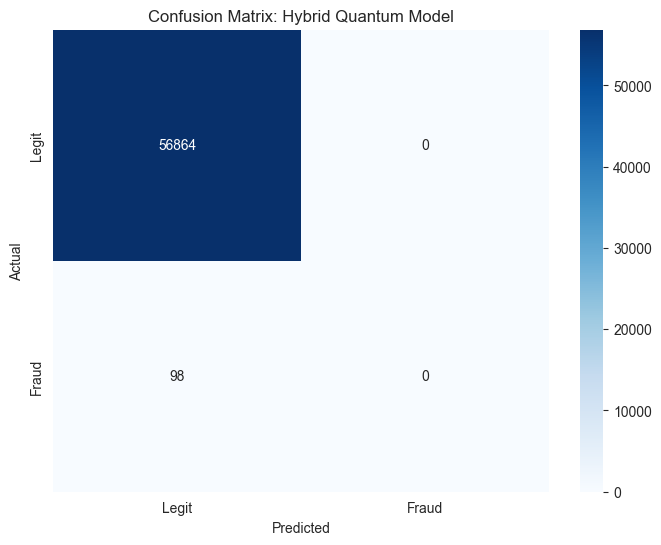

In [5]:
cm = confusion_matrix(y_true, y_pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Legit', 'Fraud'], 
            yticklabels=['Legit', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Hybrid Quantum Model')
plt.show()

### ROC Curve

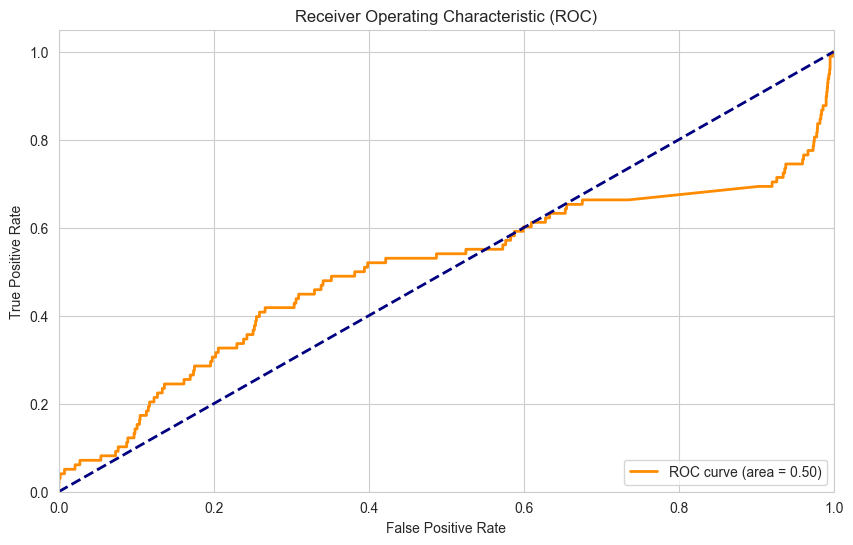

In [6]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()